# More functionalized code
Mostly using fast.ai or pytorch libraries.

In [1]:
from fastai.vision.all import *

/home/gg/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Preparing dataset

In [2]:
full_dataset_dir = untar_data(URLs.MNIST)

In [3]:
image_size=28*28 # np.prod(array(Image.open(Path.ls(full_dataset_dir/'training/3/')[0])).shape)

In [4]:
numbers= [3,7] #range(0,10)

In [5]:
def load_mnist(top_dir='testing'):
    full_dataset=[]
    labels=[]
    for number in numbers:
        path = Path.ls(full_dataset_dir/'{}/{}/'.format(top_dir,number))
        im_tensor = [ tensor(Image.open(p)) for p in path ]
        for i in range(0,len(im_tensor)): # otherwise it would simply be a list of lists
            full_dataset.append(im_tensor[i])
            labels.append(number)
    x_stack = (torch.stack(full_dataset).float()/255).view(-1,image_size)
    y_stack = tensor(labels).unsqueeze(1)
    del full_dataset,labels
    return x_stack, y_stack    

In [6]:
train_x_stack,train_y_stack= load_mnist('training')
test_x_stack,test_y_stack= load_mnist('testing')

In [7]:
train_x_stack.shape, train_y_stack.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [8]:
test_y_stack.shape, test_y_stack.shape

(torch.Size([2038, 1]), torch.Size([2038, 1]))

Assign 1 for 3s and 0 for 7s.

In [9]:
train_y_stack = (train_y_stack == 3) * 1

In [10]:
test_y_stack = (test_y_stack == 3) * 1

Requirement is that a tuple (x,y) is returned when indexed.

# Define Loss function
This function now tells how far the predictions are from targets.

We have 2 targets 0 and 1. If the target is 1, take 1-predictions.
If target is 0, take predictions.
The mean will give the accuracy of the model

In [11]:
def sigmoid(x) : return 1/(1+torch.exp(-x))

But our preds are not normalized to be in the range 0 to 1. So do that with the sigmoid function.

In [12]:
def mnist_loss(predictions,targets):
    predictions=sigmoid(predictions)
    return torch.where(targets==1,1-predictions,predictions).mean()

In [13]:
init_params = lambda size,std=1: (torch.randn(size)*std).requires_grad_()

In [14]:
weights = init_params((image_size,1)) # one param for y. for each pixel need one each
bias = init_params(1)

# Define model (linear)

In [15]:
linear1 = lambda xb: xb@weights + bias

# Meeting Pytorch requirements for Dataset

In [16]:
train_dset = list(zip(train_x_stack,train_y_stack))
test_dset = list(zip(test_x_stack,test_y_stack))

In [17]:
dl = DataLoader(train_dset,batch_size=256) # train in batches for each epoch

In [18]:
test_dl = DataLoader(test_dset,batch_size=256) # train in batches for each epoch

Test with a small batch

In [19]:
batch = train_x_stack[:100]
batch_y = train_x_stack[:100]

In [20]:
preds = linear1(batch)

In [21]:
loss = mnist_loss(preds,batch_y)
loss

tensor(0.9815, grad_fn=<MeanBackward0>)

## Calculate gradient

In [22]:
loss.backward()

In [23]:
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(0.0008), tensor([0.0077]))

## Calculate gradient function

In [24]:
def calc_grad(x,y,model=linear1):
    preds = model(x)
    loss = mnist_loss(preds,y)
    loss.backward()

In [25]:
calc_grad(batch,train_y_stack[:100])

In [26]:
weights.grad.mean(),bias.grad

(tensor(-3.1718e-06), tensor([-2.7044e-05]))

Set to zero after calling once. Else will add to existing gradient.

In [27]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

## Loop over full dataset and batches

In [28]:
def train_epoch(params,model=linear1,lr=1):
    for x, y in dl:
        calc_grad(x,y,model)
        for p in params:
            p.data -= p.grad*lr #update each parameter
            p.grad.zero_()

In [29]:
params=weights,bias

In [30]:
train_epoch(params)

## Check for one batch

In [31]:
def batch_accuracy(x,y):
    preds=x.sigmoid()
    correct= (preds>0.5) == y
    return correct.float().mean()

In [32]:
batch_pred = linear1(batch)
batch_accuracy(batch_pred,batch_y)

tensor(0.3899)

## Put all batches together

linear1 knows what the current weights and biases are. 

In [33]:
params[0].shape

torch.Size([784, 1])

In [34]:
params[1]

tensor([0.2595], requires_grad=True)

In [35]:
def validate_epoch(model=linear1):
    accs = [batch_accuracy(model(x),y) for x,y in test_dl] # all accuracies for batches
    return round(torch.stack(accs).mean().item(),4)

## Train for 50 epochs

In [37]:
accur=[]
lr=0.1
for i in range(0,50):
    train_epoch(params,linear1,lr)
    accur.append(validate_epoch(linear1))
    print('{} '.format(accur[-1]))

0.8151 
0.8546 
0.8726 
0.8853 
0.8945 
0.9038 
0.9073 
0.9112 
0.9136 
0.9166 
0.9205 
0.9235 
0.9269 
0.9294 
0.9308 
0.9332 
0.9337 
0.9342 
0.9362 
0.9377 
0.9386 
0.9396 
0.9406 
0.9421 
0.944 
0.9445 
0.9465 
0.947 
0.9489 
0.9494 
0.9499 
0.9499 
0.9504 
0.9504 
0.9504 
0.9504 
0.9509 
0.9509 
0.9514 
0.9519 
0.9519 
0.9524 
0.9529 
0.9529 
0.9534 
0.9534 
0.9539 
0.9544 
0.9553 
0.9553 


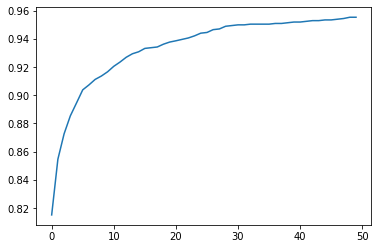

In [38]:
plt.plot(accur)
plt.show()